# PyCaret，SHAP

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import pycaret
import pandas as pd
from pycaret.regression import *
from pycaret.utils import enable_colab
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import pandas_profiling as pdp

import shap

In [2]:
enable_colab()

Colab mode enabled.


In [3]:
df = pd.read_csv('..//Data-science//data//boston.csv')

train, test = train_test_split(df, random_state=53)

## EDA

In [4]:
#pdp.ProfileReport(df, title='Boston data')

## データ入力，前処理の実行

#### setup()の実行
- 各変数の方を推定
- 推定が正しければ Enterキー，そうでなければ quit を入力
- 型の推定が誤っている変数については、setup()へ明示的に型を指定可能
- 引数 'silent = True' とすることでこのステップをスキップできる
- 'feature_selection = True' とすることで，特徴量が自動で選択される．ランダムフォレスト，AdaBoost，目的変数との線形相関といった複数のPermutation Importance の組み合わせに基づいて選択される．その際，'feature_selection_method' を'classic' か 'boruta'を指定できる．'feature_selection_threshold' を指定すること特徴量選択に使用される閾値を調整できる．値が大きいほど，選択される特徴量は多くなる．低い値に設定すると効率的ではあるが，アンダーフィットになる可能性がある．

In [5]:
reg1 = setup(data = train,
             train_size = 0.7, #学習データと検証データを7:3に分割
             target = 'house prices',
             #numeric_imputation = 'mean', # 欠損値を平均値で補完する
             categorical_features = ['CHAS'], # カテゴリ変数を指定
             #ignore_features = ['ZN', 'CHAS', 'AGE', 'RAD', 'TAX', 'B'], # 無視する特徴量を指定
             feature_selection = True,
             feature_selection_threshold=0.3, # 値が大きいほど，選択される特徴量の数が多くなる．
             feature_selection_method='classic', # Permutation Importanvceによる選択．’boruta’とするとランダムフォレストと検定を用いた特徴量選択アルゴリズムを用いる．
             normalize = True, # 標準化の有無
             normalize_method = 'zscore', # 標準化の方法（'zscore'，'minmax'，'maxabs'，'robust'）
             #pca=True, # 主成分分析による次元削除
             #pca_method='linear', # 次元削除の方法（'linear'，'kernel'）
             #profile=True, # pandas-progiling によるEDA
             #log_data=True, # 学習データと検証データのCSVへの出力
             silent = True # 型推定の確認をスキップ
             ) 

In [6]:
# 複数のモデルの実行，比較
compare_models()

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=6379, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
X = get_config('X') #全ての説明変数
X

PTRATIO     LSTAT       AGE        RM     INDUS       DIS
395  0.882875  0.769658  1.151812  0.199198  1.162286 -1.042068
165 -1.557926 -0.309805  0.948044 -0.388964  1.384822 -0.756201
282 -1.469170 -1.315332 -0.573188  1.816643 -1.033410  0.625493
146 -1.557926  0.695722  1.193970 -1.124166  1.384822 -1.137358
307  0.084067 -0.649910  0.150539  0.640320 -1.196604 -0.327399
..        ...       ...       ...       ...       ...       ...
251  0.394715 -1.226609 -2.006589  0.052158 -0.647680  1.673674
421  0.882875  0.562638  1.028848 -0.536004  1.162286 -0.946779
373  0.882875  3.386985  1.193970 -2.153449  1.162286 -1.280292
285 -1.291657 -0.546400 -1.198544  0.199198 -1.196604  1.626030
25   1.237900  0.680935  0.691577 -1.124166 -0.321293  0.291981

[379 rows x 6 columns]

In [8]:
y = get_config('y') # 全ての目的変数
y

395    13.100000
165    25.000000
282    46.000000
146    15.600000
307    28.200001
         ...    
251    24.799999
421    14.200000
373    13.800000
285    22.000000
25     13.900000
Name: house prices, Length: 379, dtype: float32

In [9]:
#X_train = get_config('X_train') # 分割後の学習用説明変数
#X_train.head()

In [10]:
#y_train = get_config('y_train') # 分割後の学習用目的変数
#y_train.head()

In [11]:
#X_val = get_config('X_test') # 分割後の検証用説明変数
#X_val.head()

In [12]:
#y_val = get_config('y_test') # 分割後の検証用目的変数
#y_val.head()

### 評価指標

- RMSE

|項目|概要|
|:----------|:---------------|
| 判断基準 | 0に近い程良い |
| 特徴         | 大きく予測を外した場合を重要視している            <br>予測を大きく外すと大幅に大きくなる傾向にある<br>回帰モデルの最も一般的な性能評価指標として用いられる |

- R2（決定係数）

|項目|概要|
|:----------|:---------------|
| 判断基準 | 0.6以下：全然予測できてない<br>0.8以上：良いモデル<br>0.9以上：過学習の可能性あり |
| 特徴         | 大きく予測を外した場合を重要視している<br>予測を大きく外すと大幅に大きくなる傾向にある              |


### 複数の推定器を個別に実行する

#### 結果，精度の可視化

- create_model() で引数として，モデルを渡すとモデルを生成できる．初期設定では，クロスバリデーション（K-Fold =10） で実行される．

- ハイパーパラメータの最適化は，tune_model() を使う．第一引数にはモデル，第二引数にはランダムグリッドサーチの回数，第三引数には最適化の対象を渡す.

- evaluate_model() によって，モデルの解析結果を表示できる．タブを切り替えることでモデルの複数の概要がわかる．
  - Error Plot
    
    横軸に実際の値，縦軸に予測値をプロットする．予測が完全であれば、傾き1の直線上に点が乗る．点が傾き1の直線周辺に集まるモデルが良いモデルになる．予測値が大きい領域では誤差が大きくなっているように見える．
  - Learning Curve（学習曲線）
  
    データ数に応じた予測精度を表示するグラフで，横軸にデータサイズ，縦軸に予測精度をプロットする．良いモデルの指標としてはデータが増えるごとにtraining scoreが減少し，cross validation scoreが増加することが望ましい．cross validation scoreとtraining scoreの差が大きかった場合は，学習数が足りてない恐れがあるため，データ数を増やすことでモデルの精度の向上が図れる．

    訓練データが少ない場合は，モデルはオーバーパラメトライズの状態になり，train-trainの精度が高く，train-testの精度が低くなります。これは過学習状態であるとも言える．過学習を起こすのは、サンプル数が少ないにも関わらず、モデルが複雑（特徴量が多い・パラメーター数が多い）すぎる場合が多い．そのため，過学習への対策として，サンプル数を増やすか、モデルのパラメーター数を減らすか（特徴量を減らすか）がある．
  - Feature Importance（寄与度）

    目的変数に及ぼす影響が大きい順に上から特徴量が上位10まで表示される．

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt

#### Extra Trees モデル

In [13]:
# Extra Trees Regressor を実行
et = create_model('et')

In [14]:
# Extra Trees Regressor のハイパーパラメータの最適化
tuned_et = tune_model(et, n_iter = 100, optimize = 'rmse')

In [15]:
# 結果の確認
evaluate_model(tuned_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [16]:
plot_model(tuned_et, plot='residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

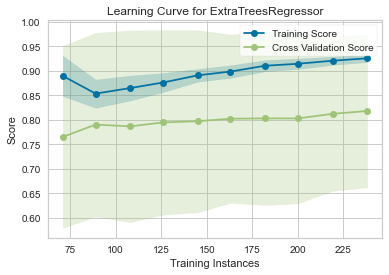

In [53]:
# 学習曲線
plot_model(tuned_et,plot='learning')

In [18]:
plot_model(tuned_et, plot='parameter')

Parameters
bootstrap                     False
ccp_alpha                       0.0
criterion                       mae
max_depth                        11
max_features                    1.0
max_leaf_nodes                 None
max_samples                    None
min_impurity_decrease        0.0002
min_impurity_split             None
min_samples_leaf                  2
min_samples_split                 7
min_weight_fraction_leaf        0.0
n_estimators                    130
n_jobs                           -1
oob_score                     False
random_state                   6379
verbose                           0
warm_start                    False

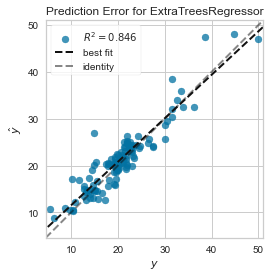

In [54]:
# Validation Curve
plot_model(tuned_et, plot='error') #save=True にすると png で保存可能

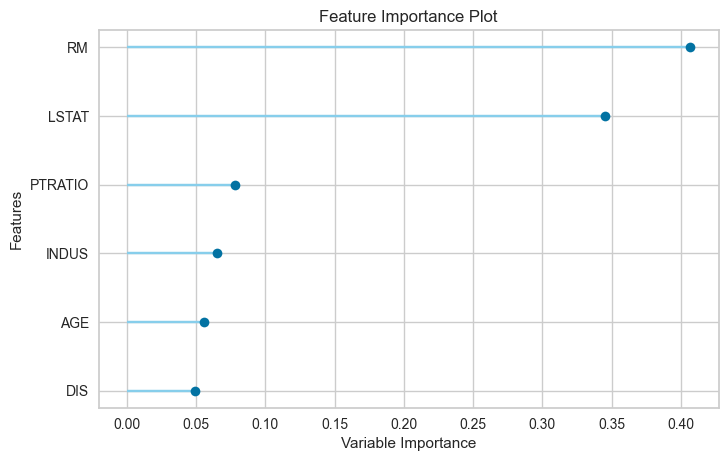

In [55]:
# Feature Importance
plot_model(tuned_et, plot='feature')

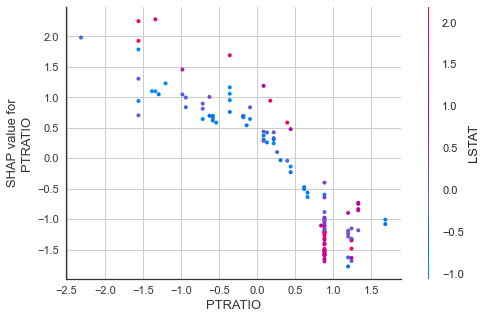

In [57]:
# SHAPによるモデルの解釈(dependence_plot)
interpret_model(tuned_et, plot = 'correlation')

In [22]:
# 予測結果
predictions_et = predict_model(tuned_et, data=test)
predictions_et.head()

CRIM   ZN  INDUS  CHAS  NOX   RM   AGE  DIS   RAD    TAX  PTRATIO      B  \
111   0.1  0.0   10.0   0.0  0.5  6.7  81.6  2.7   6.0  432.0     17.8  395.6   
236   0.5  0.0    6.2   1.0  0.5  6.6  76.5  4.1   8.0  307.0     17.4  388.4   
232   0.6  0.0    6.2   0.0  0.5  8.3  73.3  3.8   8.0  307.0     17.4  385.9   
48    0.3  0.0    6.9   0.0  0.4  5.4  95.3  5.9   3.0  233.0     17.9  396.9   
473   4.6  0.0   18.1   0.0  0.6  7.0  67.6  2.5  24.0  666.0     20.2  374.7   

     LSTAT  house prices      Label  
111   10.2          22.8  25.334231  
236    9.5          25.1  25.272308  
232    2.5          41.7  47.803846  
48    30.8          14.4  15.317308  
473   11.7          29.8  24.232692

In [23]:
save_model(tuned_et, '..//Data-science//model//et_reg')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CHAS'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='house prices',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numer...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mae', max_depth=11,
                                      max_features=1.0, max_leaf_nodes=None,
                                      max_samples=None,
 

#### Ramdom Forest の実行

In [24]:
# Random Forest Regressor を実行
rf = create_model('rf')

# Random Forest のハイパーパラメータの最適化
tuned_rf = tune_model(rf, n_iter = 100, optimize = 'rmse')

In [25]:
# 結果の確認
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

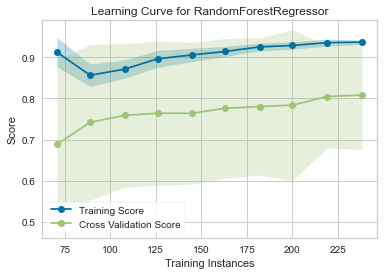

In [58]:
# 学習の精度
plot_model(estimator = tuned_rf, plot = 'learning')

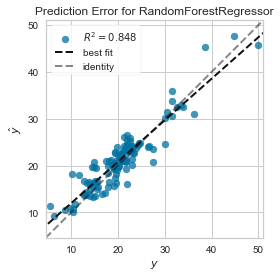

In [59]:
# Prediction Error Plot
plot_model(estimator = tuned_rf, plot = 'error')

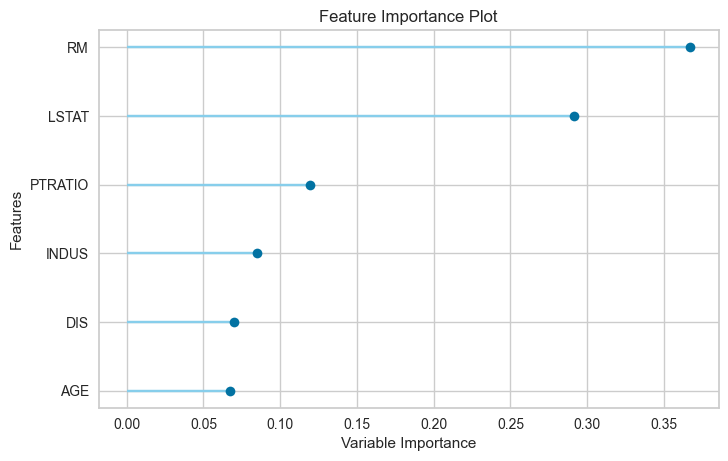

In [60]:
# Feature Importance
plot_model(estimator=tuned_rf, plot='feature')

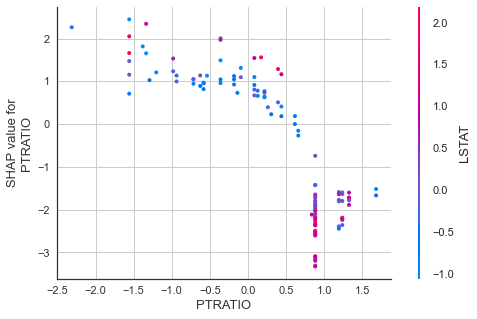

In [61]:
# SHAPによるモデルの解釈(dependence_plot)
interpret_model(tuned_rf, plot = 'correlation')

In [30]:
# 予測結果
predictions_rf = predict_model(tuned_rf, data=test)
predictions_rf.head()

CRIM   ZN  INDUS  CHAS  NOX   RM   AGE  DIS   RAD    TAX  PTRATIO      B  \
111   0.1  0.0   10.0   0.0  0.5  6.7  81.6  2.7   6.0  432.0     17.8  395.6   
236   0.5  0.0    6.2   1.0  0.5  6.6  76.5  4.1   8.0  307.0     17.4  388.4   
232   0.6  0.0    6.2   0.0  0.5  8.3  73.3  3.8   8.0  307.0     17.4  385.9   
48    0.3  0.0    6.9   0.0  0.4  5.4  95.3  5.9   3.0  233.0     17.9  396.9   
473   4.6  0.0   18.1   0.0  0.6  7.0  67.6  2.5  24.0  666.0     20.2  374.7   

     LSTAT  house prices      Label  
111   10.2          22.8  25.456296  
236    9.5          25.1  24.365185  
232    2.5          41.7  46.461852  
48    30.8          14.4  17.308148  
473   11.7          29.8  24.063519

In [31]:
save_model(tuned_rf, '..//Data-science//model//rf_reg')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CHAS'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='house prices',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numer...
                  RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                        criterion='mae', max_depth=7,
                                        max_features='log2', max_leaf_nodes=None,
                                        max_sampl

#### LightGBM の実行

In [32]:
# LightGBM を実行
lgbm = create_model('lightgbm')

# LightGBM のハイパーパラメータの最適化
tuned_lgbm = tune_model(lgbm, n_iter = 100, optimize = 'rmse')

In [33]:
# 結果の確認
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

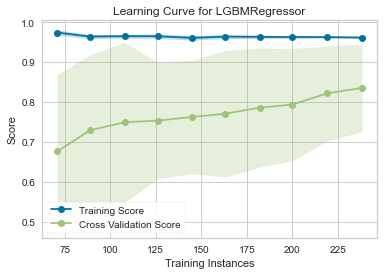

In [62]:
# 学習の精度
plot_model(estimator = tuned_lgbm, plot = 'learning')

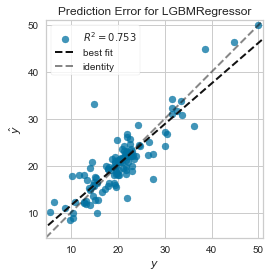

In [63]:
# Prediction Error Plot
plot_model(estimator = tuned_lgbm, plot = 'error')

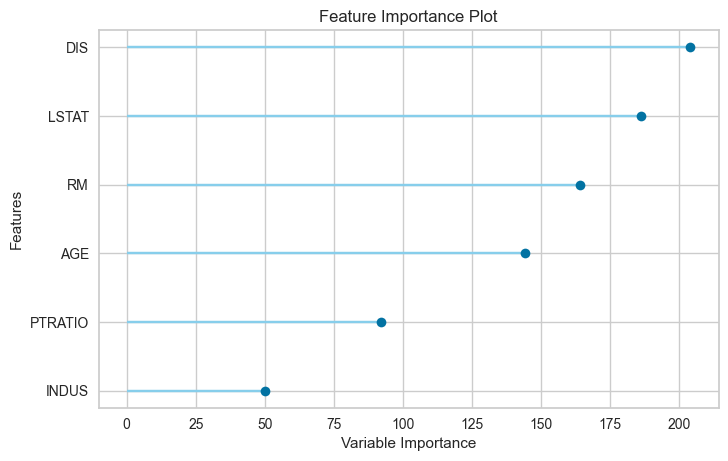

In [64]:
# Feature Importance
plot_model(estimator=tuned_lgbm, plot='feature')

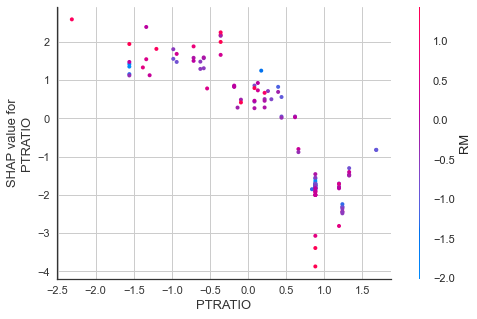

In [65]:
# SHAPによるモデルの解釈(dependence_plot)
interpret_model(tuned_lgbm, plot = 'correlation')

In [38]:
# 予測結果
predictions_lgbm = predict_model(tuned_lgbm, data=test)
predictions_lgbm.head()

CRIM   ZN  INDUS  CHAS  NOX   RM   AGE  DIS   RAD    TAX  PTRATIO      B  \
111   0.1  0.0   10.0   0.0  0.5  6.7  81.6  2.7   6.0  432.0     17.8  395.6   
236   0.5  0.0    6.2   1.0  0.5  6.6  76.5  4.1   8.0  307.0     17.4  388.4   
232   0.6  0.0    6.2   0.0  0.5  8.3  73.3  3.8   8.0  307.0     17.4  385.9   
48    0.3  0.0    6.9   0.0  0.4  5.4  95.3  5.9   3.0  233.0     17.9  396.9   
473   4.6  0.0   18.1   0.0  0.6  7.0  67.6  2.5  24.0  666.0     20.2  374.7   

     LSTAT  house prices      Label  
111   10.2          22.8  21.964929  
236    9.5          25.1  25.230306  
232    2.5          41.7  46.707817  
48    30.8          14.4  14.688090  
473   11.7          29.8  21.946024

In [39]:
save_model(tuned_lgbm, '..//Data-science//model//lgbm_reg')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CHAS'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='house prices',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numer...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=1.0,
                                importance_type='split', learning_rate=0.1,
                                max_depth=-1, mi

#### モデルのアンサンブル

アンサンブル，ブレンド，スタッキングが可能

In [40]:
ensemble = blend_models([tuned_et, tuned_rf, tuned_lgbm])

In [41]:
# スタッキング
gbr = create_model('gbr')

stacker = stack_models([tuned_et, tuned_rf, tuned_lgbm], meta_model=gbr)

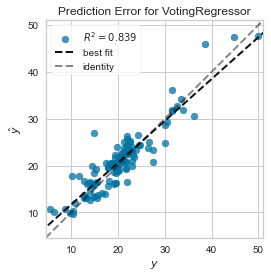

In [66]:
plot_model(ensemble, plot='error')

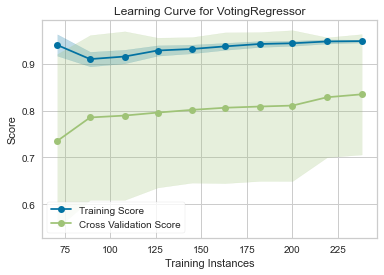

In [67]:
plot_model(ensemble, plot='learning')

In [44]:
evaluate_model(ensemble)

Parameters
estimators  [('et', ExtraTreesRegressor(bootstrap=False, c...
n_jobs                                                     -1
verbose                                                 False
weights                                                  None

In [45]:
pred_ensemble = predict_model(ensemble, data=test)
pred_ensemble

CRIM    ZN  INDUS  CHAS  NOX   RM   AGE  DIS   RAD    TAX  PTRATIO  \
111   0.1   0.0   10.0   0.0  0.5  6.7  81.6  2.7   6.0  432.0     17.8   
236   0.5   0.0    6.2   1.0  0.5  6.6  76.5  4.1   8.0  307.0     17.4   
232   0.6   0.0    6.2   0.0  0.5  8.3  73.3  3.8   8.0  307.0     17.4   
48    0.3   0.0    6.9   0.0  0.4  5.4  95.3  5.9   3.0  233.0     17.9   
473   4.6   0.0   18.1   0.0  0.6  7.0  67.6  2.5  24.0  666.0     20.2   
..    ...   ...    ...   ...  ...  ...   ...  ...   ...    ...      ...   
246   0.3  22.0    5.9   0.0  0.4  6.1  34.9  8.1   7.0  330.0     19.1   
138   0.2   0.0   21.9   0.0  0.6  5.9  98.2  1.7   4.0  437.0     21.2   
477  15.0   0.0   18.1   0.0  0.6  5.3  97.3  2.1  24.0  666.0     20.2   
432   6.4   0.0   18.1   0.0  0.6  6.4  74.8  2.2  24.0  666.0     20.2   
182   0.1   0.0    2.5   0.0  0.5  7.2  92.2  2.7   3.0  193.0     17.8   

         B  LSTAT  house prices      Label  
111  395.6   10.2          22.8  24.251819  
236  388.4    9.5          25.1  24.955933  
232  385.9    2.5          41.7  46.991172  
48   396.9   30.8          14.4  15.771182  
473  374.7   11.7          29.8  23.414078  
..     ...    ...           ...        ...  
246  390.2    9.2          24.3  22.485469  
138  392.0   21.3          13.3  12.275977  
477  349.5   24.9          12.0  11.813795  
432   98.0   12.0          16.1  20.291987  
182  394.1    4.8          37.9  35.232058  

[127 rows x 15 columns]

#### モデルの確定

In [46]:
final = finalize_model(ensemble)
print(final)

VotingRegressor(estimators=[('et',
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mae', max_depth=11,
                                                 max_features=1.0,
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0002,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=2,
                                                 min_samples_split=7,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=130, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=6379, v...
            

In [47]:
test[['CRIM', 'INDUS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']]

CRIM  INDUS  NOX   RM  DIS  PTRATIO  LSTAT
111   0.1   10.0  0.5  6.7  2.7     17.8   10.2
236   0.5    6.2  0.5  6.6  4.1     17.4    9.5
232   0.6    6.2  0.5  8.3  3.8     17.4    2.5
48    0.3    6.9  0.4  5.4  5.9     17.9   30.8
473   4.6   18.1  0.6  7.0  2.5     20.2   11.7
..    ...    ...  ...  ...  ...      ...    ...
246   0.3    5.9  0.4  6.1  8.1     19.1    9.2
138   0.2   21.9  0.6  5.9  1.7     21.2   21.3
477  15.0   18.1  0.6  5.3  2.1     20.2   24.9
432   6.4   18.1  0.6  6.4  2.2     20.2   12.0
182   0.1    2.5  0.5  7.2  2.7     17.8    4.8

[127 rows x 7 columns]

In [48]:
test.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'house prices'],
      dtype='object')

In [49]:
final.score(test[X.columns], test['house prices'])

-0.0605076606620083

In [50]:
# モデルの保存

save_model(final, '..//Data-science//model//FinalModel_reg')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['CHAS'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='house prices',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numer...
                                                             feature_fraction=1.0,
                                                             importance_type='split',
                                                             learning_rate=0.1,
                        

## SHAPによるモデルの解釈

### SHAP（SHapley Additive exPlanations）とは
SHAPとは，shapley値を用いて，予測結果に対して特徴量がどのように寄与するかを可視化する方法．

shapley値とは限界貢献度の期待値（平均値）nokoto.
機械学習に当てはめる場合．予測した値に対して，それぞれの特徴量が予測にどのような影響を与えたかを算出した値と言える．

### method
TreeExplainer()は勾配ブースティング（XGBoost, LightGBM, CatBoostなど）で作成したモデルを読み込み、shapley値を導くためのインスタンス.

#### 引数
- model_output: モデルの出力方法．margin(生データのshape値)，probability(確率空間に変換されたshapley値)，log_loss()がある．


### メリット
- 計算方法が公開されており，貢献度が数値化されるため，完全な透明性が求められる場合に有効
- データ数が少ない場合でも結果が安定
- 計算時間が少ない

### デメリット
- 計算できるアルゴリズムが限定的
- アンサンブルしたモデルには使用できない

In [68]:
%matplotlib inline

import matplotlib.pyplot as plt

import shap

In [70]:
shap.initjs()

explainer_rf = shap.TreeExplainer(model=tuned_rf, model_output='margin')

In [71]:
shap_values_rf = explainer_rf.shap_values(X=X)

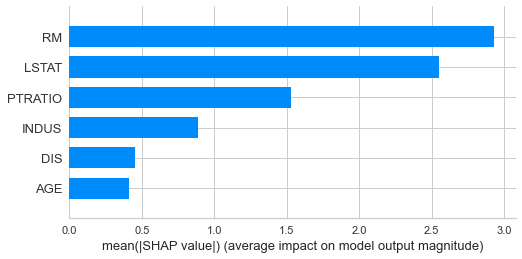

In [72]:
# rfの特徴量の重要度
shap.initjs()
shap.summary_plot(shap_values_rf, X, plot_type="bar")

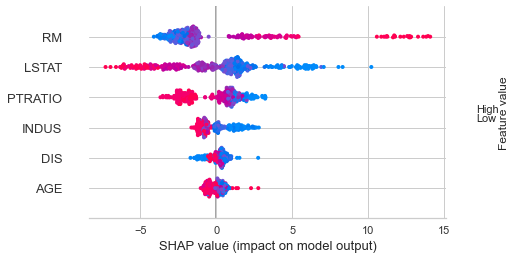

In [73]:
# rfの相関関係
shap.initjs()
shap.summary_plot(shap_values_rf, X)

In [74]:
# rfのforce_plot(shapley値と特徴変数の寄与度)
shap.initjs()
shap.force_plot(base_value=explainer_rf.expected_value, shap_values=shap_values_rf, features=X)

In [75]:
# rfのforce_plot(shapley値と特徴変数の寄与度)
shap.initjs()
shap.force_plot(base_value=explainer_rf.expected_value, shap_values=shap_values_rf[15,:], features=X.iloc[15,:])